In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df=pd.read_csv('nba_games_stats.csv')

Missing Values:
 Column1                     0
Team                        0
Game                        0
Date                        0
Home                        0
Opponent                    0
WINorLOSS                   0
TeamPoints                  0
OpponentPoints              0
FieldGoals                  0
FieldGoalsAttempted         0
FieldGoals.                 0
X3PointShots                0
X3PointShotsAttempted       0
X3PointShots.               0
FreeThrows                  0
FreeThrowsAttempted         0
FreeThrows.                 0
OffRebounds                 0
TotalRebounds               0
Assists                     0
Steals                      0
Blocks                      0
Turnovers                   0
TotalFouls                  0
Opp.FieldGoals              0
Opp.FieldGoalsAttempted     0
Opp.FieldGoals.             0
Opp.3PointShots             0
Opp.3PointShotsAttempted    0
Opp.3PointShots.            0
Opp.FreeThrows              0
Opp.FreeThrowsAttempted

<ipython-input-52-b81aa79522e1>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Opp.TotalFouls'].fillna(df['Opp.TotalFouls'].median(), inplace=True)


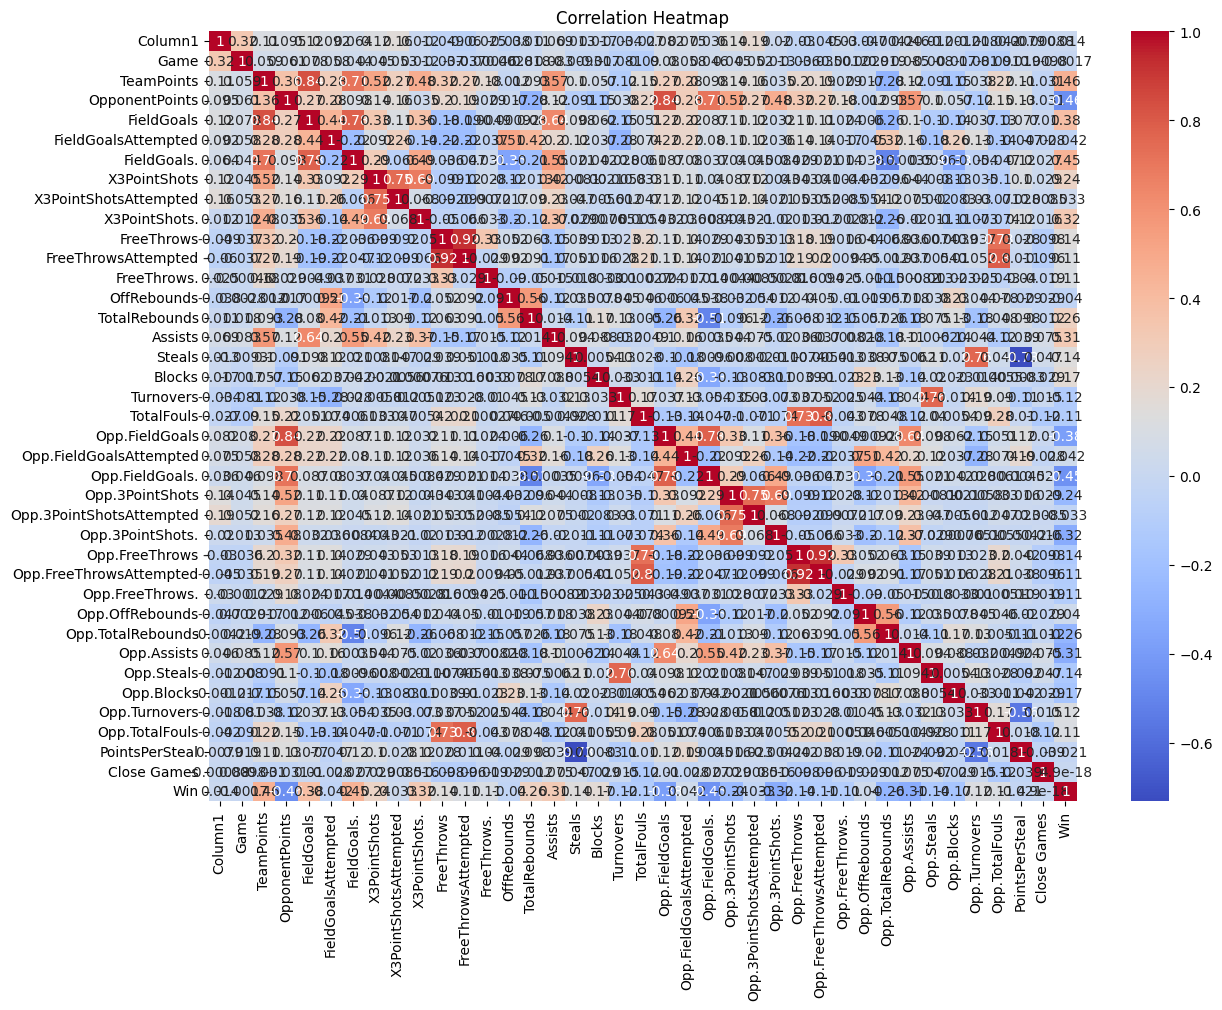

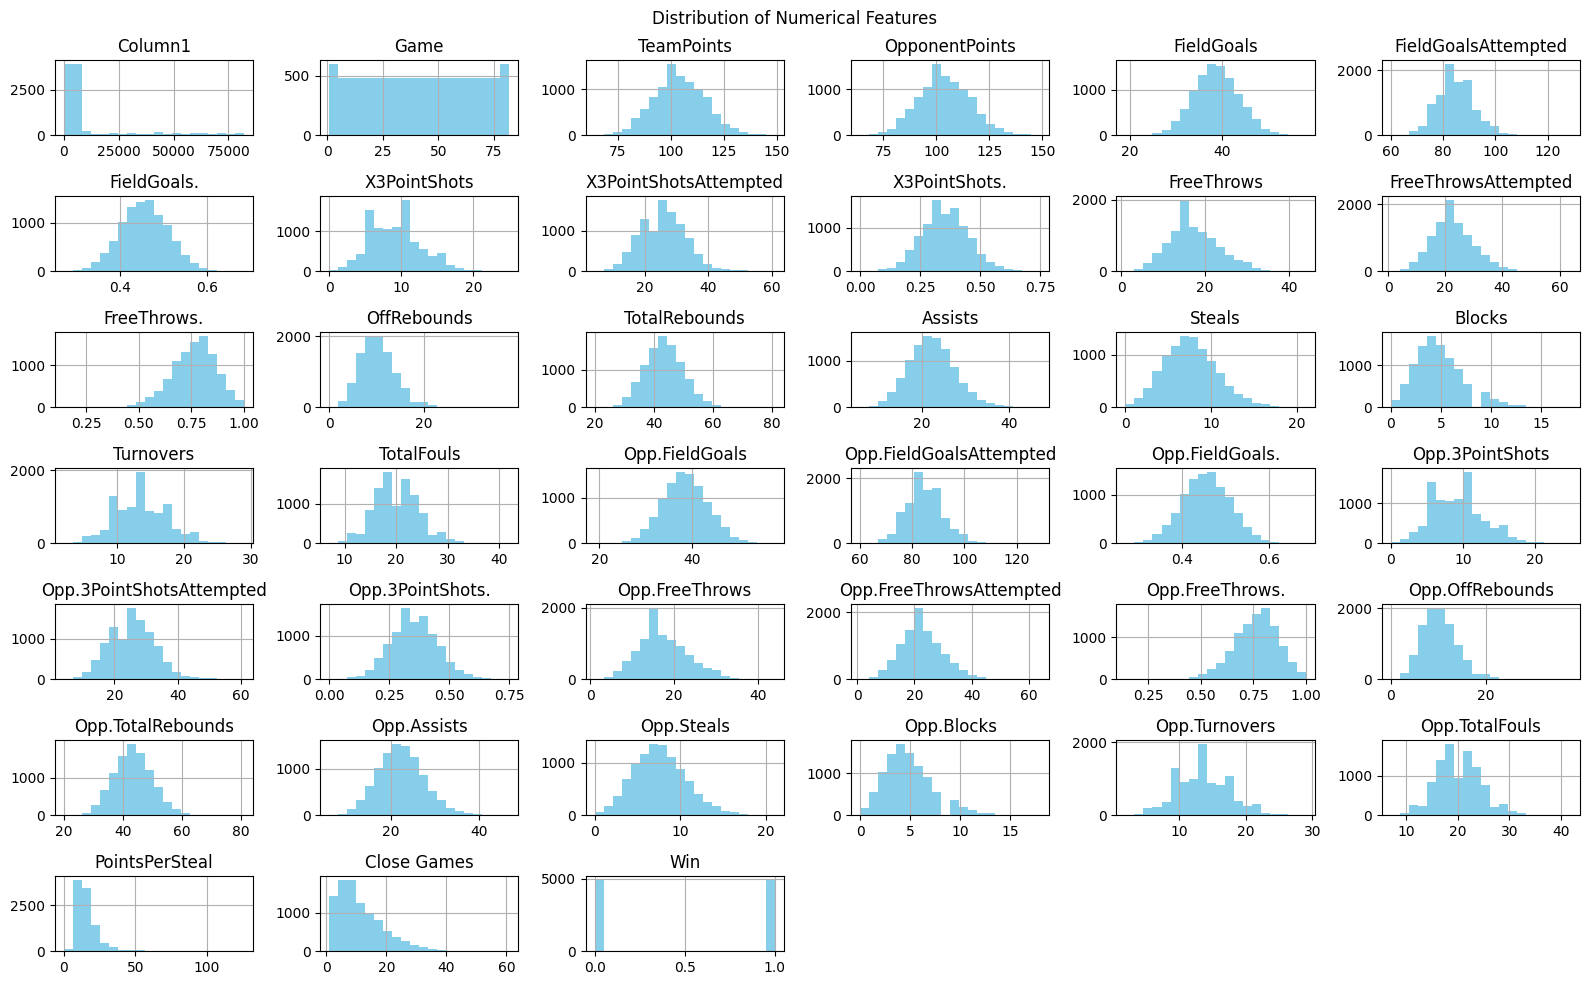

In [ ]:
#Pre Data Analysis
# Pre-analysis inspection
print("Missing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)
print("\nUnique values in 'Home':", df['Home'].unique())
print("Unique values in 'WINorLOSS':", df['WINorLOSS'].unique())
print("\nPreview:\n", df.head())
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Opp.TotalFouls'] = pd.to_numeric(df['Opp.TotalFouls'], errors='coerce')
df['Opp.TotalFouls'].fillna(df['Opp.TotalFouls'].median(), inplace=True)
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()
# Distribution of numerical features
df.select_dtypes(include=np.number).hist(bins=20,figsize=(16, 10), color='skyblue')
plt.suptitle("Distribution of Numerical Features")
plt.tight_layout()
plt.show()


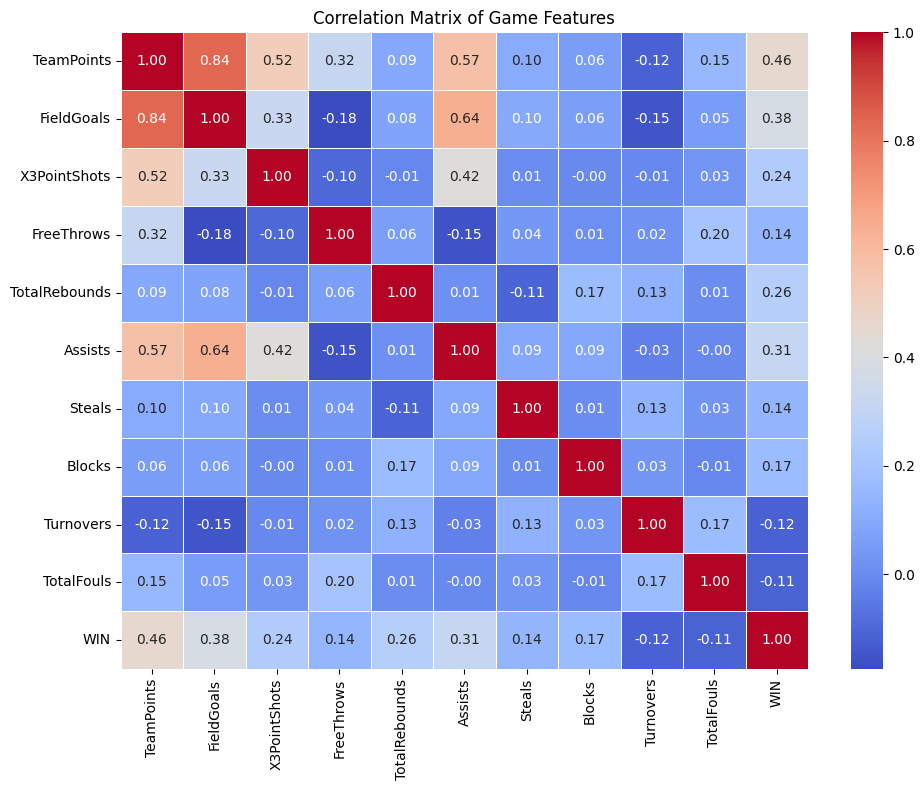

In [30]:
# Objective 1: Show correlation between performance metrics

features = ['TeamPoints', 'FieldGoals', 'X3PointShots', 'FreeThrows', 'TotalRebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers', 'TotalFouls', 'WIN']
corr = df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Game Features')
plt.tight_layout()
plt.show()


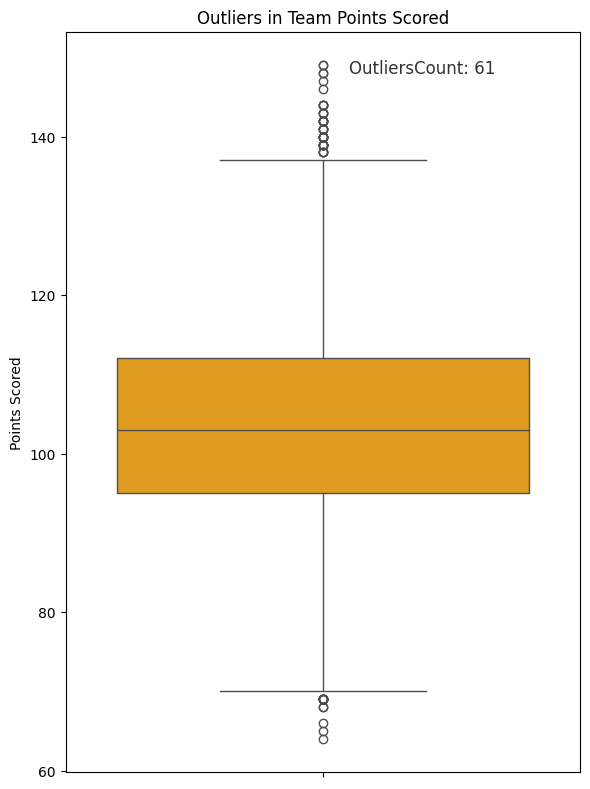

In [18]:
# Objective 2: Identify Outliers in Team Performance Based on Points Scored
Q1 = df['TeamPoints'].quantile(0.25)
Q3 = df['TeamPoints'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['TeamPoints'] < lower_bound) | (df['TeamPoints'] > upper_bound)]
outlier_count = len(outliers)
plt.figure(figsize=(6, 8))
sns.boxplot(y=df['TeamPoints'], color='orange')
plt.title('Outliers in Team Points Scored')
plt.ylabel('Points Scored')

plt.text(0.05, df['TeamPoints'].max() - 1, f'OutliersCount: {outlier_count}', fontsize=12, color='#333335')

plt.tight_layout()
plt.show()


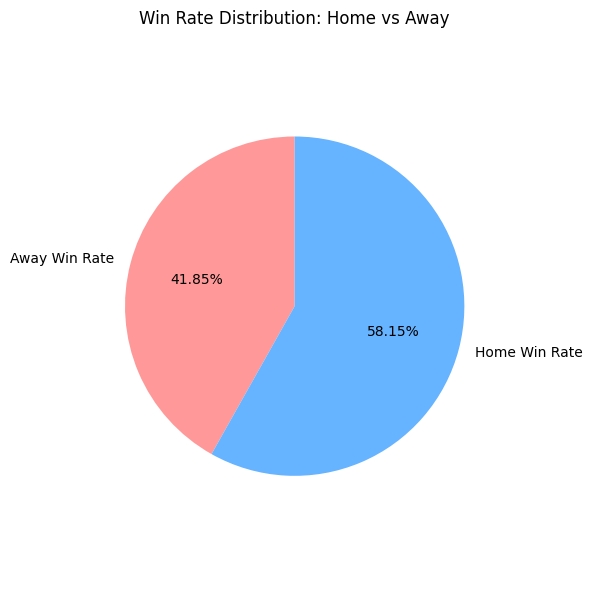

In [21]:
#Objective3: Analyze the Impact of Home vs. Away Games on Winning Percentage

home_win_rate = df.groupby('Home')['WIN'].mean()
labels = ['Away Win Rate', 'Home Win Rate']
sizes = home_win_rate.values
colors = ['#ff9999', '#66b3ff']
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, colors=colors)
plt.title('Win Rate Distribution: Home vs Away')
plt.axis('equal')

plt.tight_layout()
plt.show()



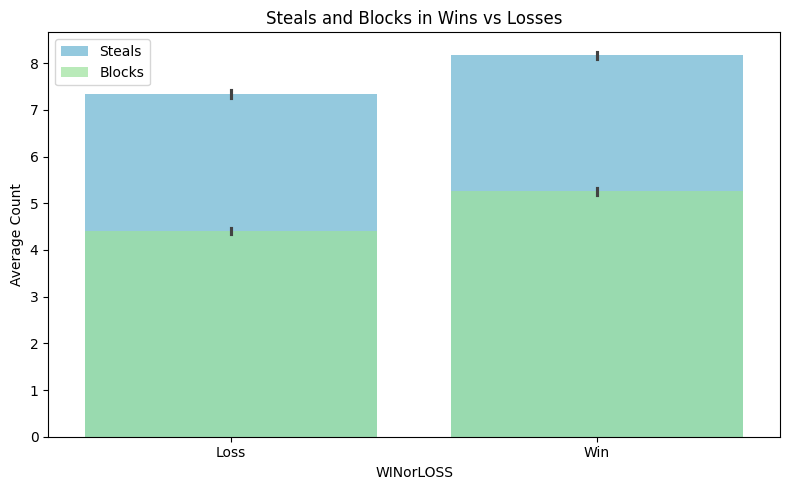

In [ ]:
# Objective4: Compare average defensive stats (Steals, Blocks) in wins and losses

plt.figure(figsize=(8, 5))
sns.barplot(x='WINorLOSS', y='Steals', data=df, errorbar=('ci', 95), label='Steals', color='skyblue')
sns.barplot(x='WINorLOSS', y='Blocks', data=df, errorbar=('ci', 95), label='Blocks', color='lightgreen', alpha=0.7)
plt.title('Steals and Blocks in Wins vs Losses')
plt.ylabel('Average Count')
plt.xticks([0, 1], ['Loss', 'Win'])
plt.legend()
plt.tight_layout()
plt.show()


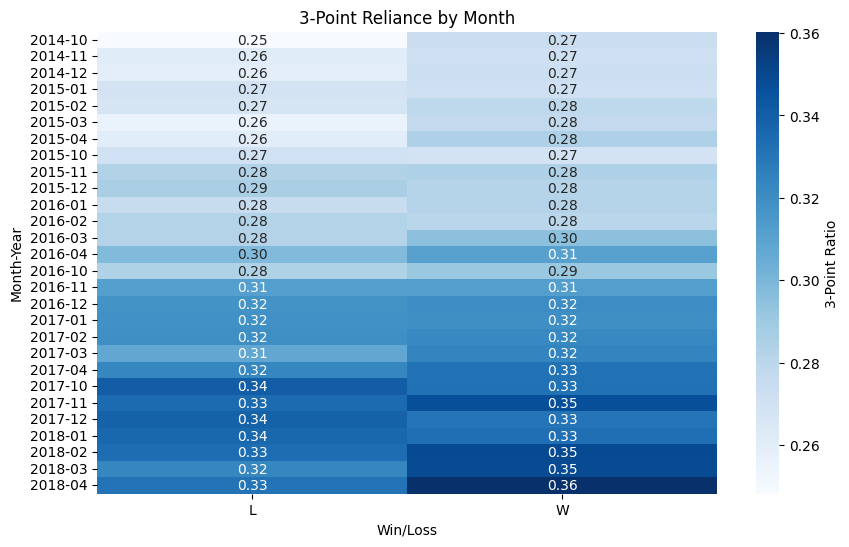

In [60]:
# Objective5: Calculate 3-point reliance
df['3Point_Ratio'] = df['X3PointShotsAttempted'] / df['FieldGoalsAttempted']
df['Date'] = pd.to_datetime(df['Date'])
df['MonthYear'] = df['Date'].dt.to_period('M')
grouped = df.groupby(['MonthYear', 'WINorLOSS'])[['3Point_Ratio', 'X3PointShots.']].mean().unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(grouped['3Point_Ratio'], annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': '3-Point Ratio'})
plt.title('3-Point Reliance by Month')
plt.xlabel('Win/Loss')
plt.ylabel('Month-Year')
plt.show()

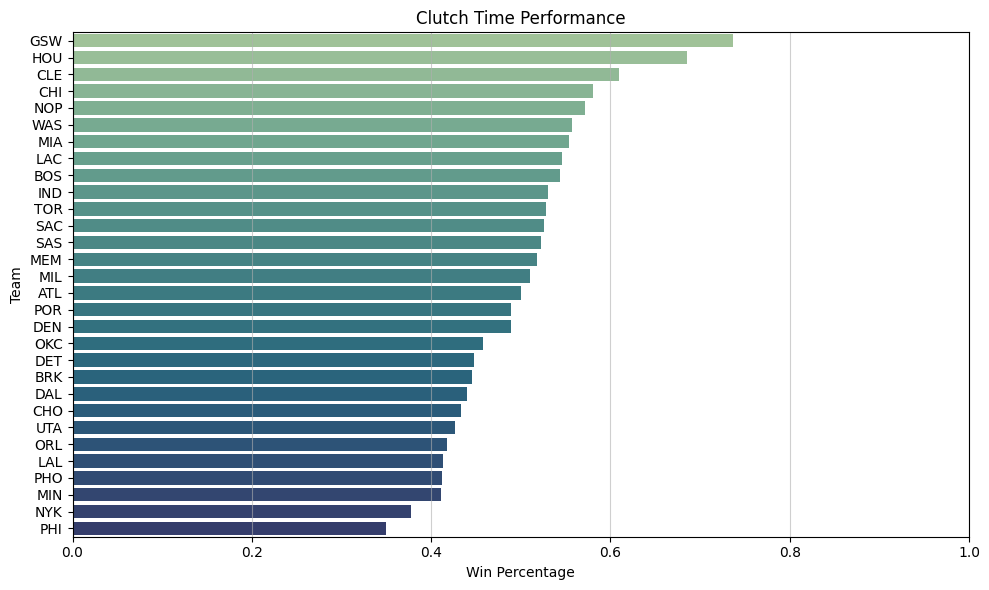

In [37]:
# Objective 6: Identify which teams perform best in clutch games (decided by 5 points or less)
df['PointDiff'] = abs(df['TeamPoints'] - df['OpponentPoints'])
clutch_games = df[df['PointDiff'] <= 5].copy()
clutch_games['WIN'] = clutch_games['WINorLOSS'].map({'W': 1, 'L': 0})
clutch_win_rate = clutch_games.groupby('Team')['WIN'].mean().sort_values(ascending=False)
clutch_win_rate_df = clutch_win_rate.reset_index().rename(columns={'WIN': 'Clutch Win %'})
plt.figure(figsize=(10, 6))
sns.barplot(data=clutch_win_rate_df, x='Clutch Win %', y='Team', hue='Team', palette='crest', legend=False)
plt.title('Clutch Time Performance')
plt.xlabel('Win Percentage')
plt.ylabel('Team')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='-', alpha=0.6)
plt.tight_layout()
plt.show()


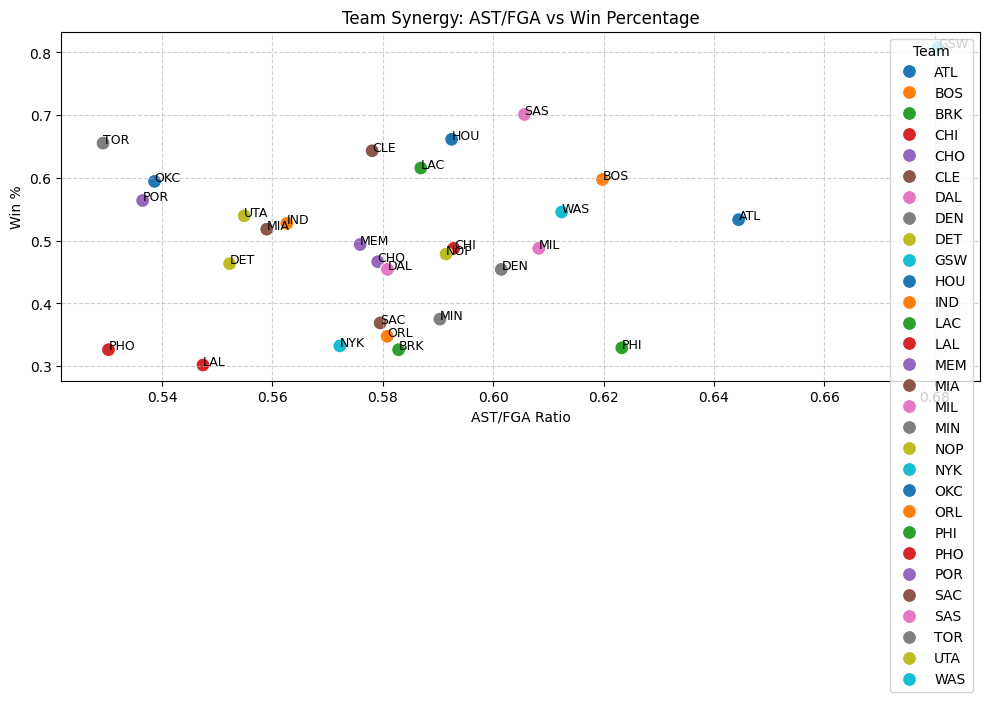

In [41]:
# Objective 7: Calculate Synergy Ratio and add it to the DataFrame
df['SynergyIndex'] = df['Assists'] / df['FieldGoals']
df['WIN'] = df['WINorLOSS'].map({'W': 1, 'L': 0})
team_synergy = df.groupby('Team').agg({
    'SynergyIndex': 'mean',
    'WIN': 'mean'
}).reset_index()
team_synergy = team_synergy.rename(columns={'SynergyIndex': 'AST/FGA Ratio', 'WIN': 'Win %'})
plt.figure(figsize=(10, 6))
sns.scatterplot(data=team_synergy, x='AST/FGA Ratio', y='Win %', hue='Team', palette='tab10', s=100)

for i in range(len(team_synergy)):
    plt.text(x=team_synergy['AST/FGA Ratio'][i],
             y=team_synergy['Win %'][i],
             s=team_synergy['Team'][i],
             fontsize=9)

plt.title('Team Synergy: AST/FGA vs Win Percentage')
plt.xlabel('AST/FGA Ratio')
plt.ylabel('Win %')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


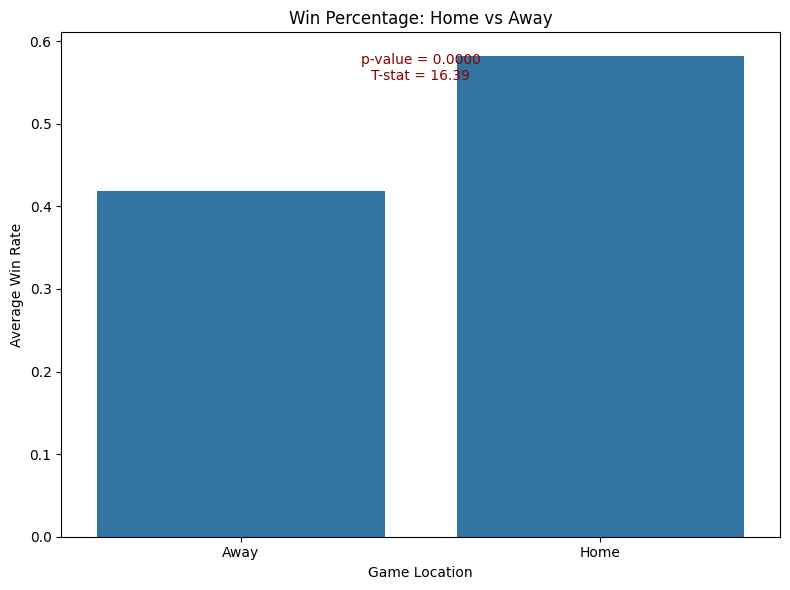

Hypothesis Test: Home Court Advantage
T-statistic = 16.3874
P-value = 0.0000
 Result: Statistically significant. Home teams have a higher win rate.


In [61]:
# Objective 8: Calculate Synergy Ratio and add it to the DataFrame
df['Win'] = df['WINorLOSS'].map({'W': 1, 'L': 0})
home_away_winrate = df.groupby('Home')['Win'].mean().reset_index()

home_wins = df[df['Home'] == 'Home']['Win']
away_wins = df[df['Home'] == 'Away']['Win']
t_stat, p_val = ttest_ind(home_wins, away_wins, equal_var=False)
plt.figure(figsize=(8, 6))
sns.barplot(data=home_away_winrate, x='Home', y='Win')
plt.title('Win Percentage: Home vs Away')
plt.ylabel('Average Win Rate')
plt.xlabel('Game Location')
plt.text(0.5, max(home_away_winrate['Win']) * 0.95,
         f'p-value = {p_val:.4f}\nT-stat = {t_stat:.2f}',
         ha='center', fontsize=10, color='darkred')
plt.tight_layout()
plt.show()
print("Hypothesis Test: Home Court Advantage")
print(f"T-statistic = {t_stat:.4f}")
print(f"P-value = {p_val:.4f}")

if p_val < 0.05:
    print(" Result: Statistically significant. Home teams have a higher win rate.")
else:
    print("Result: Not statistically significant. No clear home court advantage.")
